## Mitigatin the Fairness Issues using Pre-Processing: Data Resampling Technique

In data resampling, we try to ensure that all the sensitive groups are equally represented in our dataset.

In [23]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
import seaborn as sns
from fairlearn.preprocessing import CorrelationRemover

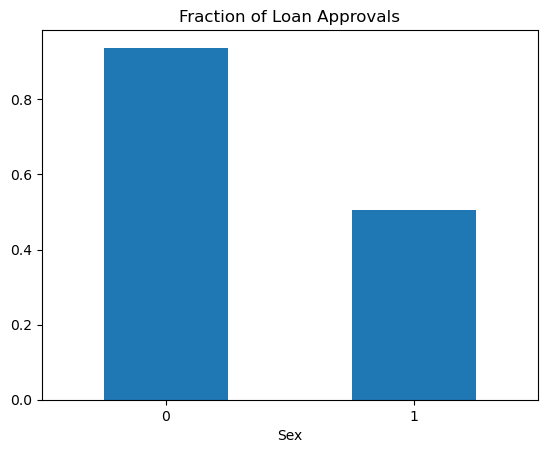

In [24]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
df = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
df.loc[df['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias
df['Loan_Approval'] = 0
df.loc[(df['Sex'] == 0) & (df['Credit_Score']/650 + df['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
df.loc[(df['Sex'] == 1) & (df['Credit_Score']/650 + df['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=df['Loan_Approval'], y_pred=df['Loan_Approval'], sensitive_features=df['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals"
)

On training data, we can downsample the samples in each group based on the minimum number of samples in the minority group considering the labels. This ensures we have same selection rate across different sensitive groups.

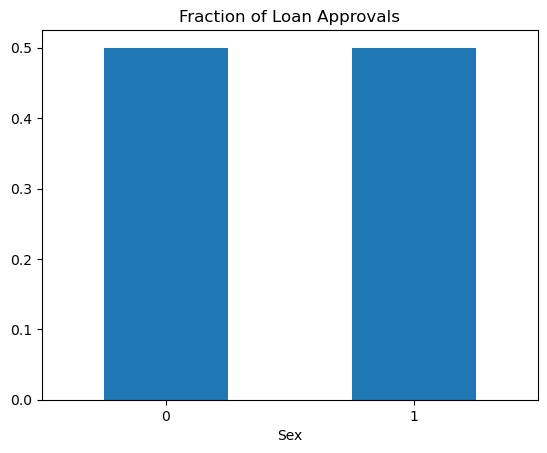

In [25]:
# Split data
train, test = train_test_split(df, test_size=0.2, random_state=42)

group_0 = train[train['Sex'] == 0]
group_1 = train[train['Sex'] == 1]

# Function to resample each subgroup to have the same number of samples
def resample_group(df, group_size):
    return df.sample(n=group_size, replace=True, random_state=42)

# Calculate the smallest number of samples among the groups
min_group_size = min(len(group_0[group_0['Loan_Approval'] == 1]), len(group_1[group_1['Loan_Approval'] == 1]))

# Resample each group to have the same number of samples
group_0_approved = resample_group(group_0[group_0['Loan_Approval'] == 1], min_group_size)
group_1_approved = resample_group(group_1[group_1['Loan_Approval'] == 1], min_group_size)

group_0_rejected = resample_group(group_0[group_0['Loan_Approval'] == 0], min_group_size)
group_1_rejected = resample_group(group_1[group_1['Loan_Approval'] == 0], min_group_size)

# Combine the resampled data back
train_resampled = pd.concat([group_0_approved, group_0_rejected, group_1_approved, group_1_rejected])

# Shuffle the resampled data
train_resampled = train_resampled.sample(frac=1).reset_index(drop=True)

# Prepare data for model training
X_train_resampled = train_resampled.drop(columns=['Loan_Approval', 'Sex'])
y_train_resampled = train_resampled['Loan_Approval']

X_test = test.drop(columns=['Loan_Approval','Sex'])
y_test = test['Loan_Approval']
sensitive_test = test['Sex']

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=train_resampled['Loan_Approval'], y_pred=train_resampled['Loan_Approval'], sensitive_features=train_resampled['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals"
)


In [26]:
# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")


Accuracy: 0.8621031746031746
AUC: 0.9528149801587302


array([[<Axes: title={'center': 'accuracy'}, xlabel='Sex'>,
        <Axes: title={'center': 'precision'}, xlabel='Sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Sex'>,
        <Axes: xlabel='Sex'>],
       [<Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>, <Axes: xlabel='Sex'>]],
      dtype=object)

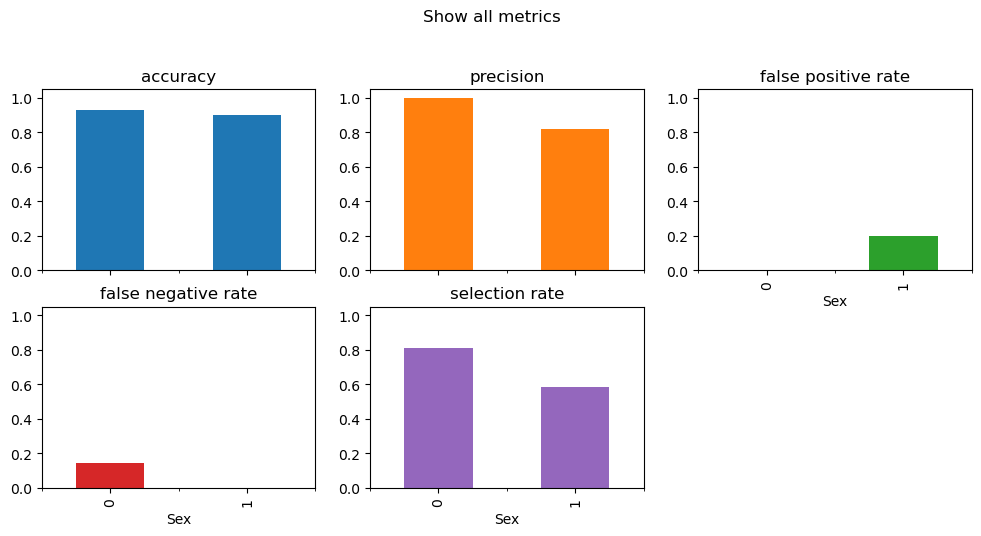

In [27]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)


In [28]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.22435897435897434
Statistical Parity ratio: 0.7222222222222222
Equalized Odds Difference: 0.2
Equalized Odds Ratio: 0.0


**Exercise 4.2:** Try implementing an upsampling method (rather than downsampling), and evalute its effect on the accuracy and fairness of the model. Discuss when we should prefer one approach over the other.

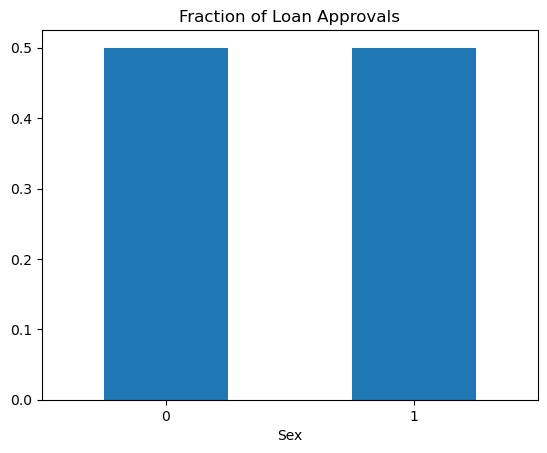

In [29]:
# upsampling method   
train, test = train_test_split(df, test_size=0.2, random_state=42)

def upsample_group(df): 
    # find minority class  
    male_count = len(df[df['Sex']==0]) 
    female_count = len(df[df['Sex']==1])
    min_size = min(male_count, female_count)  
    minority = 0 if male_count>=female_count else 1  
    majority = 1 if minority==0 else 0  
    # get majority_count
    majority_count = len(df[df['Sex']==majority]) 
    # sample duplicates or create synthetic data for minority class until it is the same size as majoriy 
    df_upsample = df[df['Sex']==minority].sample(n=majority_count, replace=True) 
    df_balanced = pd.concat([df[df['Sex'] == majority], df_upsample], axis=0, ignore_index=True) 
    df_balanced.reset_index(inplace=True)
    return df_balanced

# Shuffle the resampled data
train_upsampled = upsample_group(train)

# Prepare data for model training
X_train_resampled = train_resampled.drop(columns=['Loan_Approval', 'Sex'])
y_train_resampled = train_resampled['Loan_Approval']

X_test = test.drop(columns=['Loan_Approval','Sex'])
y_test = test['Loan_Approval']
sensitive_test = test['Sex']

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=train_resampled['Loan_Approval'], y_pred=train_resampled['Loan_Approval'], sensitive_features=train_resampled['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals"
)


In [30]:
# accuracy on the RandomForrestClassifier(random_state=42)  
rf_upsample = RandomForestClassifier(random_state=42)  
rf_upsample.fit(X_train_resampled, y_train_resampled) 
print('Accuracy of upsampling: {} \n Increase of around 2 percent compared to downsampling'.format(rf_upsample.score(X_test, y_test)) )
y_pred = rf_upsample.predict(X_test)

Accuracy of upsampling: 0.88 
 Increase of around 2 percent compared to downsampling


In [31]:
# fairness metrics of upsampling 

''

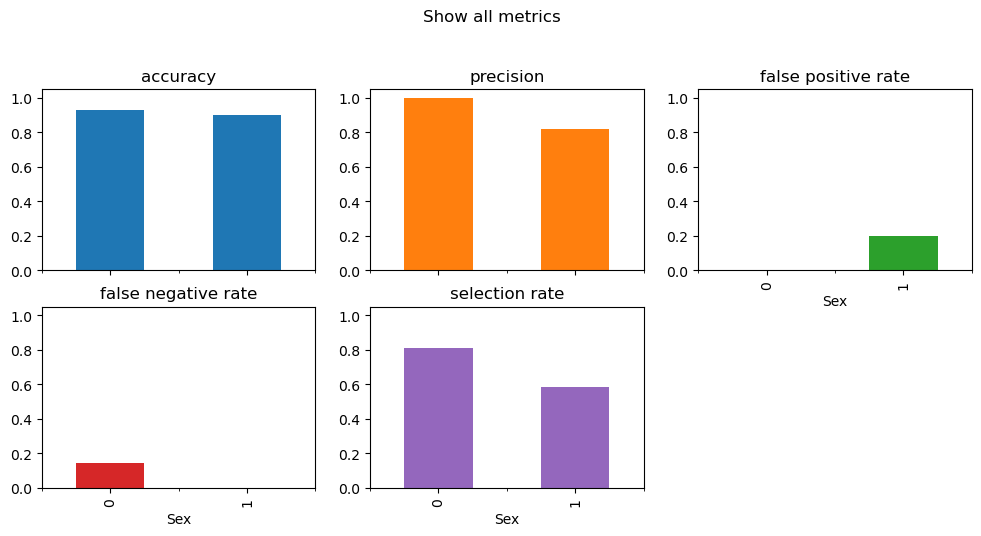

In [32]:
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)
; 
# fairness metrics are close to the same as the downsampling method, possibly because the duplication of data does not add new information 
# a synethic data generation approach may be more appropriate and lead to different fairness metrics  
# compared to the un-altered version we see no false negatives for women, implying fairer outcomes in that regard

In [33]:
# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.22435897435897434
Statistical Parity ratio: 0.7222222222222222
Equalized Odds Difference: 0.2
Equalized Odds Ratio: 0.0


Downsampling Advantages 
- when there is a severe class imbalance it may impact a model's ability to learn from the minority class, downsampling is appropriate in this scenario
- an intuition of this is that there can be situations where the minority class is so small that it is not a good approximation of the population being sampled
- down sampling also helps to not overfit the model to the majority class 

Downsampling Disadvantages  
- however with descreased data you would expect higher variance for the majority class which may lead to inconsistent performance
- you also reduce the amount of data for the majority class potentially minimizing the learning that can be done with features that are informative to both classes, and do not have a bias to either class
- 

Upsampling Advantages 
- you do not have to decrease the learning done for the majority class
- it is more appropriate when minority class is large enough that synthetic data can represent the distribution of the real population
- you achieve a more balanced class distribution so that you do not risk underfitting on the minority class

Upsampling Disadvantages  
- simply duplicating the data can risk overfitting on the minority class
- it is more computationally expensive than downsampling